# Introducción: Comparación de Algoritmos sobre Fashion‑MNIST

**Integrantes:**
- Castrejón Bringas, Melanny Angeles
- Coronado Rodriguez, Augusto Takeshi
- Díaz Rodríguez, Carlo Franco
- Ramos Guerra, Ainhoa Jolie 

Este notebook documenta el trabajo práctico de la Unidad 3: comparar el desempeño de redes neuronales frente a algoritmos clásicos de Machine Learning en la clasificación de imágenes del dataset Fashion‑MNIST.

> **Nota:** en este proyecto, implementaremos únicamente el algoritmo clásico Naive Bayes (GaussianNB); las secciones de KNN, SVM y Random Forest quedan omitidas.

Objetivos principales
- Implementar y entrenar Naive Bayes (GaussianNB) y redes neuronales (Dense y CNN).
- Evaluar y comparar métricas (accuracy, precision, recall, F1) y tiempos de entrenamiento/predicción.
- Analizar errores por clase y presentar visualizaciones comparativas.

Dataset
- Fashion‑MNIST: imágenes en escala de grises 28×28, 60.000 muestras de entrenamiento y 10.000 de prueba, 10 clases (Camiseta/Top, Pantalón, Suéter, Vestido, Abrigo, Sandalia, Camisa, Zapatilla, Bolso, Botín).

Estructura del notebook
1. Preparación y exploración de datos: carga, visualización, normalización y aplanado para modelos clásicos (Naive Bayes) y redes neuronales.
2. Modelos clásicos: implementación y evaluación de Naive Bayes (GaussianNB) — baseline y mejoras recomendadas.
3. Redes neuronales: red densa y CNN (arquitecturas sugeridas), curvas de entrenamiento y evaluación final.
4. Análisis comparativo: tabla de métricas, análisis por clase y visualizaciones.
5. Conclusiones y recomendaciones.

Entregables y métricas
- Métricas: Accuracy, Precision (macro/micro), Recall (macro/micro), F1 (macro/micro).
- Entregables: código documentado, gráficas de entrenamiento, matrices de confusión, tabla comparativa de métricas y tiempos, y un breve reporte con conclusiones.

## Paso 0: Instalación e Importación de Librerias

### Instalación de Librerias y Dependencias

In [1]:
# Instalación de librerias y dependencias
# Usando uv (https://docs.astral.sh/uv/) como gestor de paquetes y versiones de python
!uv add --dev ipykernel uv
!uv add tensorflow keras pandas numpy seaborn matplotlib


Resolved 85 packages in 1ms
Audited 79 packages in 0.03ms
Resolved 85 packages in 2ms
Audited 53 packages in 0.44ms


### Importación y Configuración Inicial

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Configurar matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

print("Librerías importadas exitosamente!")
print(f" Versiones:")
print(f"   • TensorFlow: {tf.__version__}")
print(f"   • Keras: {keras.__version__}")

# Configurar reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

Librerías importadas exitosamente!
 Versiones:
   • TensorFlow: 2.20.0
   • Keras: 3.11.3


## Paso 1: Preparación y Exploración de Datos

Actividades principales:

1. Carga y exploración inicial
   - Cargar el dataset Fashion‑MNIST desde `keras.datasets.fashion_mnist`.
   - Mostrar tamaño de los conjuntos de entrenamiento y prueba.
   - Visualizar muestras representativas de cada una de las 10 clases.
   - Analizar la distribución de clases y detectar desequilibrios.

2. Preprocesamiento
   - Normalizar los píxeles a rango [0, 1].
   - Aplanar imágenes a vectores de 784 dimensiones para los modelos clásicos.
   - Preparar one‑hot encodings y partición train/validation para redes neuronales.

Entregables:
- Gráficos de muestras por clase.
- Estadísticas básicas (shape, distribución de clases).
- Código claramente documentado para el preprocesamiento.

### Carga y Exploración de Datos

Cargando dataset Fashion MNIST...
Dataset cargado exitosamente!
Información del dataset:
------------------------
   • Datos de entrenamiento: (60000, 28, 28)
   • Etiquetas de entrenamiento: (60000,)
   • Datos de prueba: (10000, 28, 28)
   • Etiquetas de prueba: (10000,)
Propiedades básicas:
--------------------
   • Tipo de datos: uint8
   • Rango de valores: 0 - 255
   • Forma de una imagen: (28, 28)
   • Clases únicas: [0 1 2 3 4 5 6 7 8 9]

 Distribución de clases en entrenamiento:
     Prenda 0: 6,000 ejemplos
     Prenda 1: 6,000 ejemplos
     Prenda 2: 6,000 ejemplos
     Prenda 3: 6,000 ejemplos
     Prenda 4: 6,000 ejemplos
     Prenda 5: 6,000 ejemplos
     Prenda 6: 6,000 ejemplos
     Prenda 7: 6,000 ejemplos
     Prenda 8: 6,000 ejemplos
     Prenda 9: 6,000 ejemplos


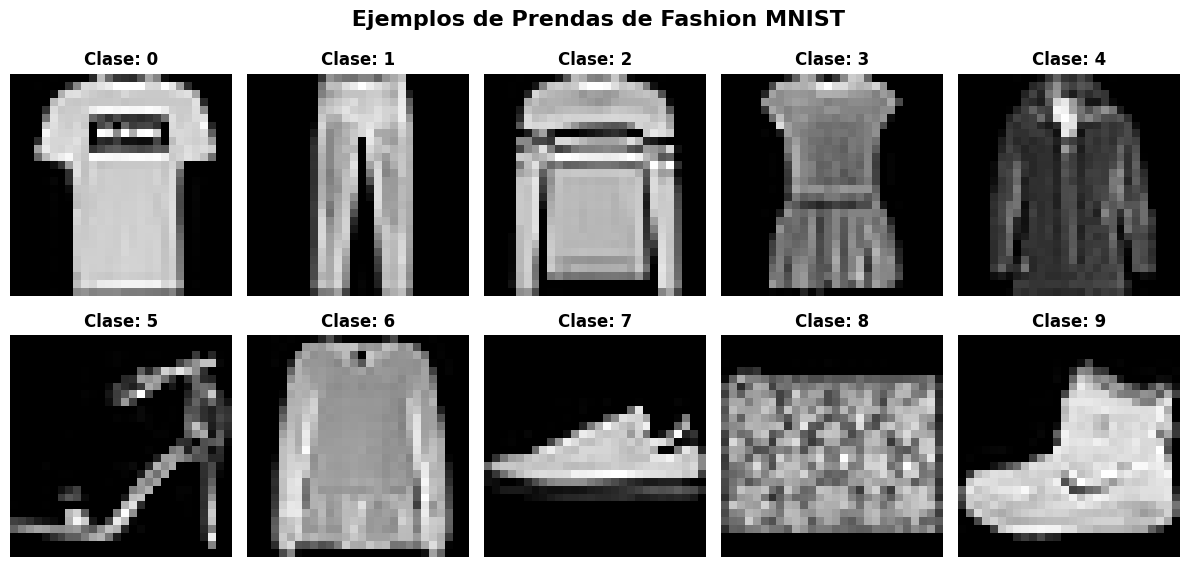

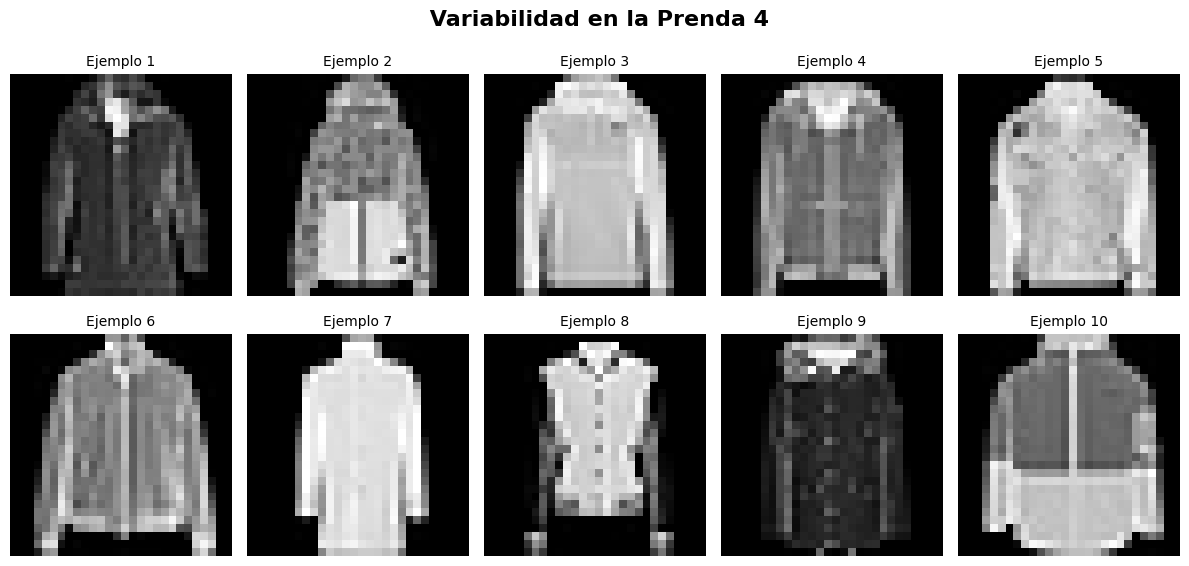

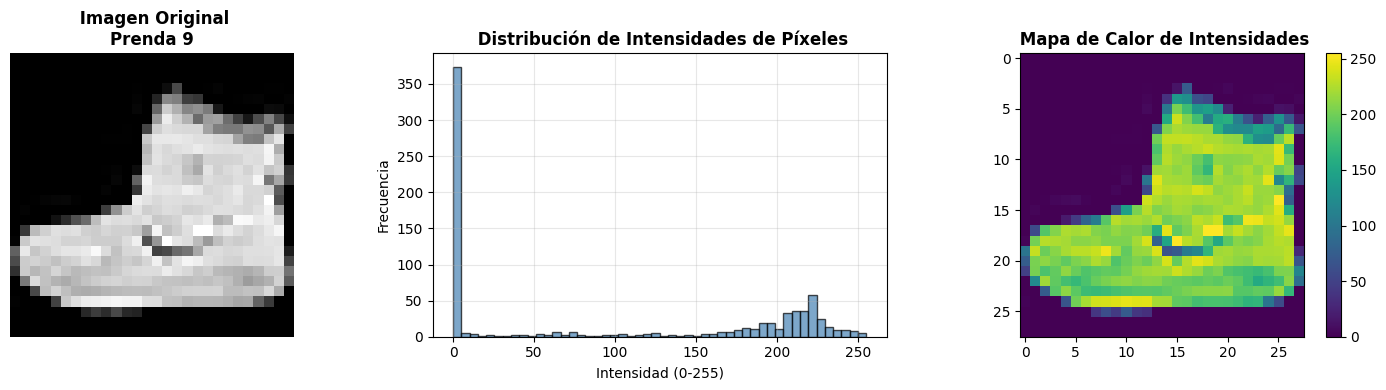

 Estadísticas de la Imagen de la Prenda 9:
   • Media: 97.25
   • Desviación estándar: 101.79
   • Píxeles no-cero: 433 de 784
   • Porcentaje de píxeles activos: 55.2%


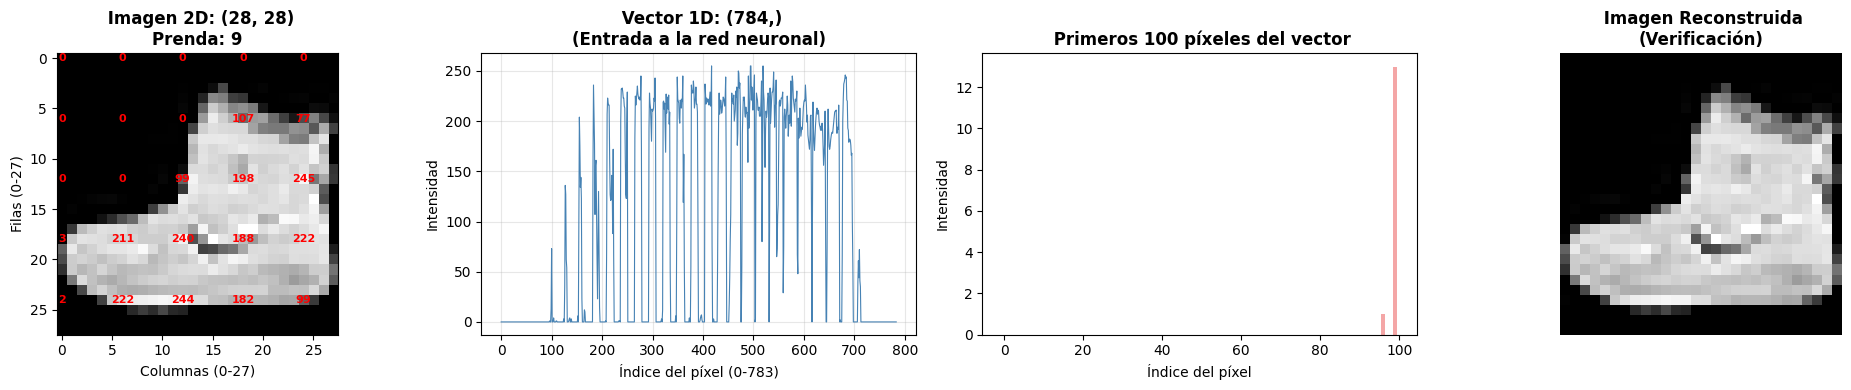

 ANÁLISIS DEL PROCESO:
   1. Imagen original: matriz de (28, 28)
   2. Aplanada: vector de (784,)
   3. Cada píxel representa la intensidad en esa posición
   4. La red neuronal verá estos 784 números como entrada
   5. Debe aprender a reconocer patrones en estos 784 valores


In [3]:
# Paso 1 — Preparación y Exploración de Datos (bloque ejecutable limpio)
# Carga, visualización, normalización, aplanado y partición train/validation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Cargar datos MNIST
print("Cargando dataset Fashion MNIST...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Dataset cargado exitosamente!")
print("========================================")
print(f"Información del dataset:")
print("------------------------")
print(f"   • Datos de entrenamiento: {X_train.shape}")
print(f"   • Etiquetas de entrenamiento: {y_train.shape}")
print(f"   • Datos de prueba: {X_test.shape}")
print(f"   • Etiquetas de prueba: {y_test.shape}")

# Explorar propiedades básicas del dataset
print("========================================")
print(f"Propiedades básicas:")
print("--------------------")
print(f"   • Tipo de datos: {X_train.dtype}")
print(f"   • Rango de valores: {X_train.min()} - {X_train.max()}")
print(f"   • Forma de una imagen: {X_train[0].shape}")
print(f"   • Clases únicas: {np.unique(y_train)}")

# Contar ejemplos por clase
unique, counts = np.unique(y_train, return_counts=True)
print(f"\n Distribución de clases en entrenamiento:")
for clothing, count in zip(unique, counts):
    print(f"     Prenda {clothing}: {count:,} ejemplos")

###  Visualización de Ejemplos por Prenda

# Visualizar ejemplos de cada dígito (0-9)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle(' Ejemplos de Prendas de Fashion MNIST', fontsize=16, fontweight='bold')

for clothing in range(10):
    # Encontrar el primer ejemplo de cada clase
    idx = np.where(y_train == clothing)[0][0]
    row, col = clothing // 5, clothing % 5

    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'Clase: {clothing}', fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Variabilidad Intra-Clase

# Mostrar múltiples ejemplos del mismo dígito para ver variabilidad
cloth_to_analyze = 4  # Cambiar por cualquier dígito 0-9
indices = np.where(y_train == cloth_to_analyze)[0][:10]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle(f' Variabilidad en la Prenda {cloth_to_analyze}', fontsize=16, fontweight='bold')

for i, idx in enumerate(indices):
    row, col = i // 5, i % 5
    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'Ejemplo {i+1}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

###  Análisis de Intensidad de Píxeles

# Analizar la distribución de intensidades de píxeles
sample_image = X_train[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Imagen original
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f' Imagen Original\nPrenda {y_train[0]}', fontweight='bold')
axes[0].axis('off')

# Histograma de intensidades
axes[1].hist(sample_image.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_title(' Distribución de Intensidades de Píxeles', fontweight='bold')
axes[1].set_xlabel('Intensidad (0-255)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)

# Mapa de calor 3D de la imagen
im = axes[2].imshow(sample_image, cmap='viridis')
axes[2].set_title(' Mapa de Calor de Intensidades', fontweight='bold')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

# Mostrar estadísticas de la imagen
print(f" Estadísticas de la Imagen de la Prenda {y_train[0]}:")
print(f"   • Media: {sample_image.mean():.2f}")
print(f"   • Desviación estándar: {sample_image.std():.2f}")
print(f"   • Píxeles no-cero: {np.count_nonzero(sample_image):,} de {sample_image.size:,}")
print(f"   • Porcentaje de píxeles activos: {np.count_nonzero(sample_image)/sample_image.size*100:.1f}%")

### Visualización de la Transformación 2D → 1D

# Mostrar cómo se convierte una imagen 2D en vector 1D
sample_idx = 0
sample_image = X_train[sample_idx]
sample_label = y_train[sample_idx]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Imagen original 28x28
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f' Imagen 2D: {sample_image.shape}\nPrenda: {sample_label}', fontweight='bold')
axes[0].set_xlabel('Columnas (0-27)')
axes[0].set_ylabel('Filas (0-27)')

# Mostrar algunos valores de píxeles
for i in range(0, 28, 6):
    for j in range(0, 28, 6):
        axes[0].text(j, i, f'{sample_image[i,j]:.0f}',
                    ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Vector 1D
flattened = sample_image.flatten()
axes[1].plot(flattened, linewidth=0.8, color='steelblue')
axes[1].set_title(f' Vector 1D: {flattened.shape}\n(Entrada a la red neuronal)', fontweight='bold')
axes[1].set_xlabel('Índice del píxel (0-783)')
axes[1].set_ylabel('Intensidad')
axes[1].grid(True, alpha=0.3)

# Mostrar las primeras 100 componentes del vector
axes[2].bar(range(100), flattened[:100], width=1.0, color='lightcoral', alpha=0.7)
axes[2].set_title(' Primeros 100 píxeles del vector', fontweight='bold')
axes[2].set_xlabel('Índice del píxel')
axes[2].set_ylabel('Intensidad')

# Reconstruir la imagen desde el vector para verificar
reconstructed = flattened.reshape(28, 28)
axes[3].imshow(reconstructed, cmap='gray')
axes[3].set_title(' Imagen Reconstruida\n(Verificación)', fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(" ANÁLISIS DEL PROCESO:")
print(f"   1. Imagen original: matriz de {sample_image.shape}")
print(f"   2. Aplanada: vector de {flattened.shape}")
print(f"   3. Cada píxel representa la intensidad en esa posición")
print(f"   4. La red neuronal verá estos {len(flattened)} números como entrada")
print(f"   5. Debe aprender a reconocer patrones en estos {len(flattened)} valores")


### Preprocesamiento de Datos

 PREPROCESAMIENTO DE DATOS:
   Antes de normalizar - Rango: [0, 255]
   Después de normalizar - Rango: [0.000, 1.000]


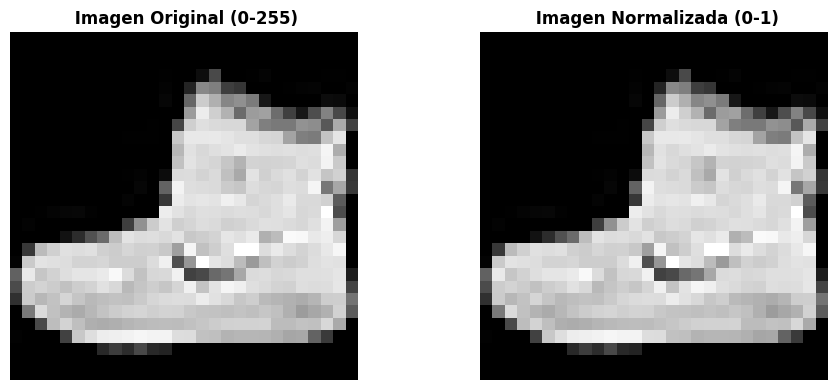


 TRANSFORMACIÓN DE FORMA:
   X_train original: (60000, 28, 28)
   X_train_flat: (60000, 784)
   Cada imagen 28×28 = 784 píxeles se convierte en vector de 784 elementos

  CODIFICACIÓN ONE-HOT:
   y_train original shape: (60000,)
   y_train_onehot shape: (60000, 10)

   Ejemplos de codificación one-hot:
     Prenda 9 → [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     Prenda 3 → [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


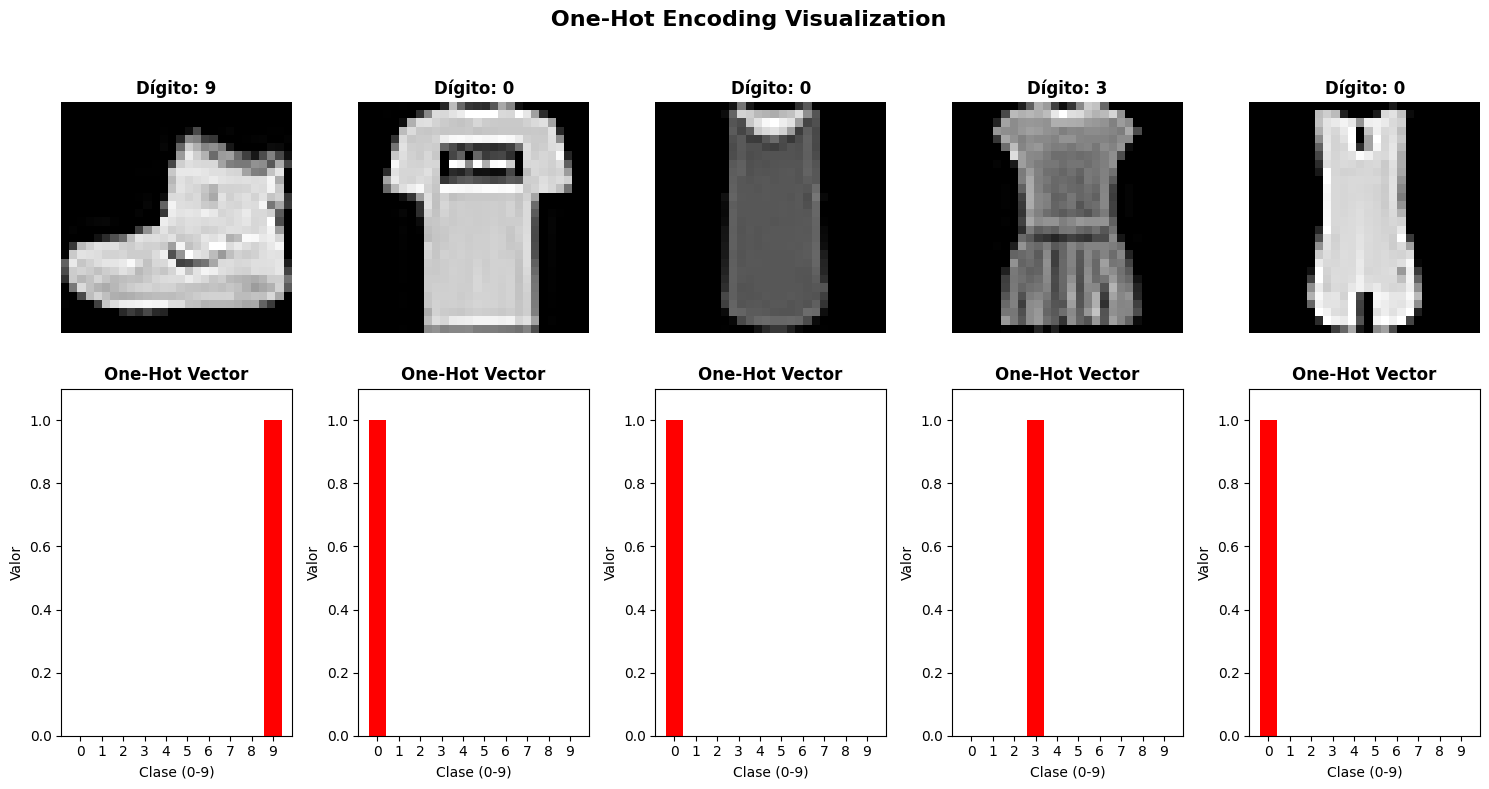

In [4]:
# Normalizar píxeles a rango [0,1]
print(" PREPROCESAMIENTO DE DATOS:")
print(f"   Antes de normalizar - Rango: [{X_train.min()}, {X_train.max()}]")

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"   Después de normalizar - Rango: [{X_train.min():.3f}, {X_train.max():.3f}]")

# Visualizar el efecto de la normalización
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Imagen sin normalizar (recreada para visualización)
original_image = (X_train[0] * 255).astype('uint8')
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title(' Imagen Original (0-255)', fontweight='bold')
axes[0].axis('off')

# Imagen normalizada
axes[1].imshow(X_train[0], cmap='gray')
axes[1].set_title(' Imagen Normalizada (0-1)', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Aplanar imágenes de 28x28 a vector 784x1
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # (10000, 784)

print(f"\n TRANSFORMACIÓN DE FORMA:")
print(f"   X_train original: {X_train.shape}")
print(f"   X_train_flat: {X_train_flat.shape}")
print(f"   Cada imagen 28×28 = {28*28} píxeles se convierte en vector de 784 elementos")

# Convertir etiquetas a codificación one-hot
y_train_onehot = np.eye(10)[y_train]  # (60000, 10)
y_test_onehot = np.eye(10)[y_test]    # (10000, 10)

print(f"\n  CODIFICACIÓN ONE-HOT:")
print(f"   y_train original shape: {y_train.shape}")
print(f"   y_train_onehot shape: {y_train_onehot.shape}")

# Mostrar ejemplos de one-hot encoding
print("\n   Ejemplos de codificación one-hot:")
for i in range(5):
    print(f"     Prenda {y_train[i]} → {y_train_onehot[i]}")

###  Visualización One-Hot Encoding

# Visualizar el concepto de one-hot
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle(' One-Hot Encoding Visualization', fontsize=16, fontweight='bold')

for i in range(5):
    # Mostrar imagen
    axes[0, i].imshow(X_train[i], cmap='gray')
    axes[0, i].set_title(f'Dígito: {y_train[i]}', fontweight='bold')
    axes[0, i].axis('off')

    # Mostrar codificación one-hot como barras
    bars = axes[1, i].bar(range(10), y_train_onehot[i],
                         color=['red' if j == y_train[i] else 'lightblue' for j in range(10)])
    axes[1, i].set_title('One-Hot Vector', fontweight='bold')
    axes[1, i].set_xlabel('Clase (0-9)')
    axes[1, i].set_ylabel('Valor')
    axes[1, i].set_ylim(0, 1.1)
    axes[1, i].set_xticks(range(10))

plt.tight_layout()
plt.show()

## Parte 2: Algoritmos Clásicos

Implementación específica para este grupo:

- Naive Bayes (GaussianNB) — Implementar y evaluar como baseline.
  - Entrenar con los vectores aplanados.
  - Explorar preprocesados recomendados: escalado (StandardScaler/MinMax), PCA (50–200 componentes) y búsquedas de `var_smoothing`.
  - Evaluar tiempos de entrenamiento y predicción.
  - Generar matriz de confusión y reporte de clasificación.

Se omiten las implementaciones directas de KNN, SVM y Random Forest por alcance de grupo; se pueden mantener notas y celdas comentadas para referencia.

Entregables para esta parte:
- Código entrenando GaussianNB sobre los datos aplanados.
- Matriz de confusión y métricas (accuracy, precision, recall, F1‑score).
- Análisis de preprocesamiento y tiempos.

### Mejoras recomendadas — GaussianNB (baseline)

- Preprocesado: escalar/normalizar las features (StandardScaler o MinMax); eliminar ruido y outliers.
- Reducir dimensionalidad con PCA/TruncatedSVD (50–200 componentes) para quitar redundancia.
- Selección de features (VarianceThreshold, SelectKBest) si hay muchas columnas.
- Ajustes de modelo: explorar `var_smoothing` en log-space (1e-12 → 1e-3) y `fit_prior`/`class_prior`.
- Pipeline: usar Pipeline(Scaler, PCA, GaussianNB) y Grid/RandomSearch con validación estratificada.
- Alternativa: si los features no son gaussianos, probar MultinomialNB/BernoulliNB tras transformar.


Entrenando GaussianNB (baseline clásico)...
GaussianNB test accuracy: 0.5856 (train time 0.37s)


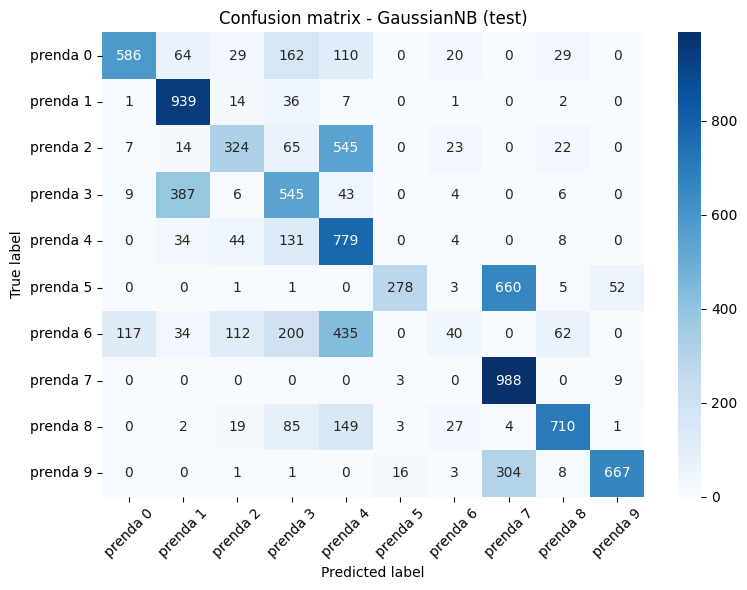

Classification report (test):
              precision    recall  f1-score   support

    prenda 0       0.81      0.59      0.68      1000
    prenda 1       0.64      0.94      0.76      1000
    prenda 2       0.59      0.32      0.42      1000
    prenda 3       0.44      0.55      0.49      1000
    prenda 4       0.38      0.78      0.51      1000
    prenda 5       0.93      0.28      0.43      1000
    prenda 6       0.32      0.04      0.07      1000
    prenda 7       0.51      0.99      0.67      1000
    prenda 8       0.83      0.71      0.77      1000
    prenda 9       0.91      0.67      0.77      1000

    accuracy                           0.59     10000
   macro avg       0.64      0.59      0.56     10000
weighted avg       0.64      0.59      0.56     10000



In [5]:
# GaussianNB (baseline) — preprocesado y entrenamiento
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Aplanar para modelos clásicos
# X_train_flat = X_train.reshape((X_train.shape[0], -1))
# X_test_flat = X_test.reshape((X_test.shape[0], -1))

print('Entrenando GaussianNB (baseline clásico)...')
start = time.time()
gnb = GaussianNB()
gnb.fit(X_train_flat, y_train)
train_time = time.time() - start

# Evaluación
y_pred_test = gnb.predict(X_test_flat)
acc_test = accuracy_score(y_test, y_pred_test)
print(f'GaussianNB test accuracy: {acc_test:.4f} (train time {train_time:.2f}s)')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
# Etiquetas: 'prenda n' donde n es el índice de clase según el número de filas de la matriz de confusión
num_classes = cm.shape[0]
labels = [f'prenda {i}' for i in range(num_classes)]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Confusion matrix - GaussianNB (test)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

print('Classification report (test):')
print(classification_report(y_test, y_pred_test, target_names=labels))


## Parte 3: Redes Neuronales

3.1 Red Neuronal Simple (Dense) — 10 pts
- Arquitectura sugerida:
  - Input: 784 neuronas (imágenes aplanadas)
  - Dense 128 + ReLU
  - Dense 64 + ReLU
  - Dense 10 + Softmax
- Usar `categorical_crossentropy` y métricas de accuracy.

3.2 Red Convolucional (CNN) — 20 pts
- Arquitectura sugerida:
  - Conv2D(32, 3x3) + ReLU + MaxPooling
  - Conv2D(64, 3x3) + ReLU + MaxPooling
  - Flatten
  - Dense(128) + ReLU + Dropout(0.5)
  - Dense(10) + Softmax
- Aplicar data augmentation como bonus opcional.

Entregables:
- Implementación de ambas redes.
- Gráficas de loss y accuracy durante entrenamiento.
- Evaluación en el conjunto de prueba y análisis de overfitting/underfitting.

### Mejoras recomendadas — Dense (MLP)

- Preprocesado: mantener normalización (0–1) o usar StandardScaler; considerar reusar imágenes en formato 2D para augmentación.
- Arquitectura: experimentar con más capas/unidades (ej. 256→128→64), BatchNorm y activaciones modernas (ReLU/Swish).
- Regularización: Dropout (0.2–0.5), L2 weight decay (1e-4–1e-2) y BatchNorm entre capas.
- Optimización: ajustar learning_rate (1e-4–1e-2), probar Adam y SGD+momentum; usar ReduceLROnPlateau.
- Entrenamiento: early stopping, checkpoints, probar batch sizes 64–256, y monitorizar curvas train/val.
- Búsqueda de hiperparámetros: RandomizedSearch/Optuna para lr, layers, units, dropout, l2, batch_size.
- Diagnóstico: matriz de confusión y curvas de aprendizaje para detectar under/overfitting.


In [6]:
# Construir modelo Dense (MLP)
def build_simple_dense_model(input_shape=(784,), num_classes=10, compile_model=True, learning_rate=0.001):
    """Builds a simple MLP:
    Input -> Dense(128, relu) -> Dense(64, relu) -> Dense(num_classes, softmax)

    Args:
        input_shape (tuple): shape of the input (e.g., (784,)).
        num_classes (int): number of output classes.
        compile_model (bool): whether to compile the model before returning.
        learning_rate (float): Adam optimizer learning rate.

    Returns:
        tf.keras.Model: the constructed (and optionally compiled) model.
    """
    from keras import layers, models, optimizers

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    if compile_model:
        model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model



Entrenando modelo Dense (MLP) con callbacks...
Epoch 1/50


375/375 - 2s - 5ms/step - accuracy: 0.8044 - loss: 0.5717 - val_accuracy: 0.8488 - val_loss: 0.4388
Epoch 2/50


375/375 - 1s - 3ms/step - accuracy: 0.8562 - loss: 0.4050 - val_accuracy: 0.8608 - val_loss: 0.4006
Epoch 3/50


375/375 - 1s - 3ms/step - accuracy: 0.8686 - loss: 0.3677 - val_accuracy: 0.8693 - val_loss: 0.3698
Epoch 4/50


375/375 - 1s - 3ms/step - accuracy: 0.8768 - loss: 0.3388 - val_accuracy: 0.8706 - val_loss: 0.3628
Epoch 5/50


375/375 - 1s - 3ms/step - accuracy: 0.8848 - loss: 0.3162 - val_accuracy: 0.8727 - val_loss: 0.3573
Epoch 6/50


375/375 - 1s - 3ms/step - accuracy: 0.8914 - loss: 0.2986 - val_accuracy: 0.8718 - val_loss: 0.3557
Epoch 7/50


375/375 - 1s - 3ms/step - accuracy: 0.8970 - loss: 0.2848 - val_accuracy: 0.8755 - val_loss: 0.3434
Epoch 8/50
375/375 - 1s - 3ms/step - accuracy: 0.9012 - loss: 0.2719 - val_accuracy: 0.8747 - val_loss: 0.3455
Epoch 9/50
375/375 - 1s - 3ms/step - accuracy: 0.9047 - loss: 0.2625 - val_accuracy: 0.8759 - val_loss: 0.3447
Epoch 10/50


375/375 - 1s - 3ms/step - accuracy: 0.9073 - loss: 0.2527 - val_accuracy: 0.8774 - val_loss: 0.3374
Epoch 11/50


375/375 - 1s - 3ms/step - accuracy: 0.9104 - loss: 0.2439 - val_accuracy: 0.8808 - val_loss: 0.3361
Epoch 12/50
375/375 - 1s - 3ms/step - accuracy: 0.9140 - loss: 0.2343 - val_accuracy: 0.8806 - val_loss: 0.3384
Epoch 13/50
375/375 - 1s - 3ms/step - accuracy: 0.9163 - loss: 0.2276 - val_accuracy: 0.8820 - val_loss: 0.3394
Epoch 14/50
375/375 - 1s - 3ms/step - accuracy: 0.9185 - loss: 0.2206 - val_accuracy: 0.8808 - val_loss: 0.3451
Dense test accuracy (evaluate): 0.8724
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
Dense test accuracy (from preds): 0.8724


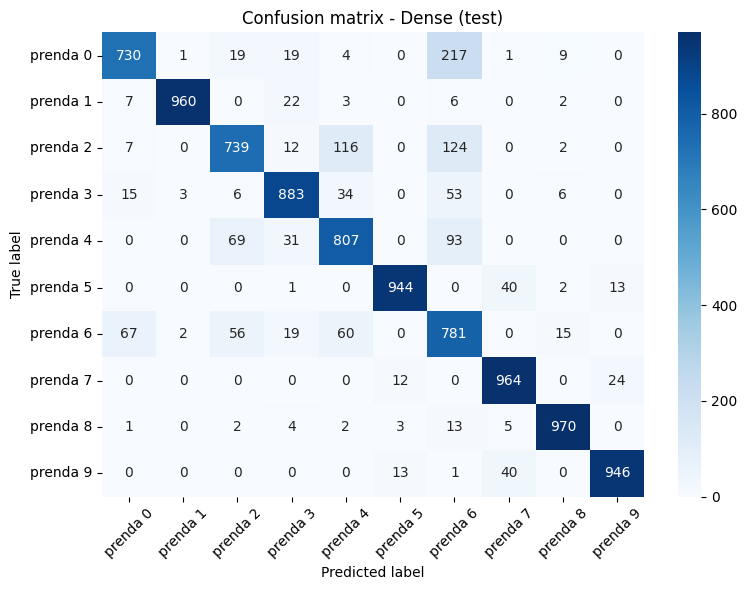

Classification report (test) - Dense:
              precision    recall  f1-score   support

    prenda 0       0.88      0.73      0.80      1000
    prenda 1       0.99      0.96      0.98      1000
    prenda 2       0.83      0.74      0.78      1000
    prenda 3       0.89      0.88      0.89      1000
    prenda 4       0.79      0.81      0.80      1000
    prenda 5       0.97      0.94      0.96      1000
    prenda 6       0.61      0.78      0.68      1000
    prenda 7       0.92      0.96      0.94      1000
    prenda 8       0.96      0.97      0.97      1000
    prenda 9       0.96      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



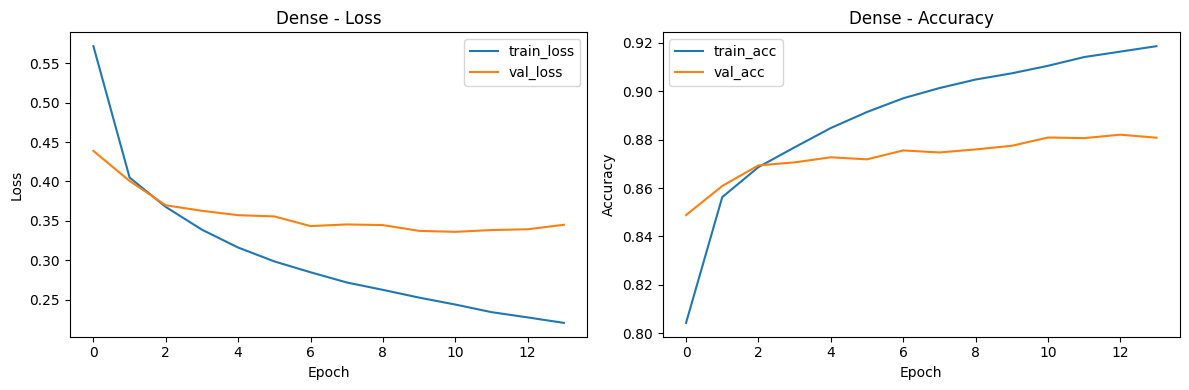

In [7]:
# Dense (MLP) — entrenamiento y evaluación (con callbacks + métricas completas)
from keras.callbacks import EarlyStopping, ModelCheckpoint
print('\nEntrenando modelo Dense (MLP) con callbacks...')

# Preparar datos aplanados (ya normalizados en la celda GaussianNB)
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Construir y compilar el modelo
model_dense = build_simple_dense_model(
    input_shape=(784,), 
    num_classes=10, 
    compile_model=True, 
    learning_rate=0.001)

callbacks_dense = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('dense_best.h5', save_best_only=True)
]

# Entrenamiento
history_dense = model_dense.fit(X_train_flat, y_train,
                              epochs=50,
                              batch_size=128,
                              validation_split=0.2,
                              callbacks=callbacks_dense,
                              verbose=2)

# Evaluación con evaluate
loss_d, acc_d = model_dense.evaluate(X_test_flat, y_test, verbose=0)
print(f'Dense test accuracy (evaluate): {acc_d:.4f}')

# Guardar history en resultados
results = globals().get('results', {})
results['dense'] = {'test_acc': acc_d, 'history': history_dense.history}
globals()['results'] = results

# ---------- Métricas adicionales: predicciones, matriz de confusión, reporte de clasificación ----------
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predicciones del modelo (argmax sobre probabilidades)
y_pred_dense = model_dense.predict(X_test_flat).argmax(axis=1)
acc_from_preds = accuracy_score(y_test, y_pred_dense)
print(f'Dense test accuracy (from preds): {acc_from_preds:.4f}')

# Matriz de confusión
cm_dense = confusion_matrix(y_test, y_pred_dense)
plt.figure(figsize=(8,6))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Confusion matrix - Dense (test)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print('Classification report (test) - Dense:')
print(classification_report(y_test, y_pred_dense, target_names=labels))

# ---------- Curvas de entrenamiento (loss / accuracy) ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_dense.history.get('loss', []), label='train_loss')
plt.plot(history_dense.history.get('val_loss', []), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Dense - Loss')

plt.subplot(1,2,2)
# Keras may use 'accuracy' or 'acc' depending on version
acc_key = 'accuracy' if 'accuracy' in history_dense.history else 'acc'
val_acc_key = 'val_' + acc_key
plt.plot(history_dense.history.get(acc_key, []), label='train_acc')
plt.plot(history_dense.history.get(val_acc_key, []), label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Dense - Accuracy')
plt.tight_layout()
plt.show()


### Mejoras recomendadas — CNN

- Preprocesado y augmentación: aplicar data augmentation (rotations, shifts, zoom, horizontal flip) usando `ImageDataGenerator` o `tf.keras.layers.Random*` para aumentar la robustez; probar normalización por canal (mean/std) o `StandardScaler` si procede.
- Arquitectura: experimentar con bloques convolucionales más profundos (ej. 3–4 bloques), cambiar filtros (32→64→128), usar convoluciones separables (`SeparableConv2D`) para eficiencia, y probar `GlobalAveragePooling2D` en lugar de `Flatten`.
- Regularización: usar BatchNormalization tras convoluciones, Dropout en el clasificador (0.2–0.5), y L2 weight decay (1e-4–1e-2) en capas densas/convolucionales.
- Optimización y scheduler: probar optimizadores (AdamW, RMSprop, SGD+momentum) y schedulers como `ReduceLROnPlateau`, `CosineAnnealing` o `ExponentialDecay` para lr; usar warmup si se entrena con lr altos.
- Augmented training setups: entrenamiento con mixup/cutmix, label smoothing y entrenamiento con batch normalization en modo correcto (no congelar en train).
- Hyperparameter search: usar Optuna/keras-tuner para explorar lr, batch_size, number of filters, kernel_size, dropout, weight decay y augmentation params.
- Transfer learning: probar modelos preentrenados (MobileNetV2, EfficientNet-lite) con fine-tuning si el dominio es cercano y los recursos lo permiten; usar `include_top=False` + custom head.
- Batch size y batch norm: experimentar con batch sizes mayores si la memoria lo permite; cuando use BatchNorm, ajustar lr y batch_size conjuntamente.
- Early stopping & checkpoints: mantener EarlyStopping y ModelCheckpoint (guardar mejores pesos); además, considerar guardar checkpoints por epoca para reanudar búsquedas largas.
- Evaluación y diagnóstico: usar augmentación en test-time (TTA) para robustez, analizar matriz de confusión por clase, curvas ROC/PR por clase si aplica, y grad-CAM/saliency para inspeccionar decisiones del modelo.
- Optimización para despliegue: cuantización (post-training quantization), pruning y versiones ligeras (MobileNet/TF-Lite) si necesita desplegar en dispositivos con recursos limitados.


In [8]:
# Construir modelo CNN
def build_cnn_model(input_shape=(28,28,1), num_classes=10, compile_model=True, learning_rate=0.001, dropout_rate=0.5):
    """Builds a simple CNN:
    Conv2D(32,3x3)+ReLU+MaxPool -> Conv2D(64,3x3)+ReLU+MaxPool -> Flatten -> Dense(128)+ReLU -> Dropout -> Dense(num_classes, softmax)

    Args:
        input_shape (tuple): shape for the image input, e.g. (28,28,1).
        num_classes (int): number of output classes.
        compile_model (bool): whether to compile before returning.
        learning_rate (float): Adam learning rate.
        dropout_rate (float): dropout rate after dense.

    Returns:
        tf.keras.Model
    """
    from keras import layers, models, optimizers

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # Bloque 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))

    # Bloque 2
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))

    # Clasificador
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    if compile_model:
        model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Ejemplo de uso (comentar si no quiere ejecutarlo ahora):
# cnn = build_cnn_model()
# cnn.summary()



Entrenando CNN con callbacks...
Epoch 1/50


375/375 - 10s - 27ms/step - accuracy: 0.7723 - loss: 0.6337 - val_accuracy: 0.8579 - val_loss: 0.3859
Epoch 2/50


375/375 - 9s - 25ms/step - accuracy: 0.8544 - loss: 0.4070 - val_accuracy: 0.8767 - val_loss: 0.3257
Epoch 3/50


375/375 - 9s - 25ms/step - accuracy: 0.8723 - loss: 0.3518 - val_accuracy: 0.8896 - val_loss: 0.2939
Epoch 4/50


375/375 - 9s - 24ms/step - accuracy: 0.8844 - loss: 0.3182 - val_accuracy: 0.8986 - val_loss: 0.2698
Epoch 5/50


375/375 - 9s - 25ms/step - accuracy: 0.8924 - loss: 0.2952 - val_accuracy: 0.9013 - val_loss: 0.2643
Epoch 6/50


375/375 - 9s - 25ms/step - accuracy: 0.9001 - loss: 0.2750 - val_accuracy: 0.9062 - val_loss: 0.2552
Epoch 7/50


375/375 - 9s - 25ms/step - accuracy: 0.9050 - loss: 0.2576 - val_accuracy: 0.9072 - val_loss: 0.2469
Epoch 8/50


375/375 - 10s - 26ms/step - accuracy: 0.9116 - loss: 0.2409 - val_accuracy: 0.9093 - val_loss: 0.2391
Epoch 9/50


375/375 - 11s - 29ms/step - accuracy: 0.9164 - loss: 0.2268 - val_accuracy: 0.9134 - val_loss: 0.2348
Epoch 10/50


375/375 - 11s - 29ms/step - accuracy: 0.9204 - loss: 0.2177 - val_accuracy: 0.9157 - val_loss: 0.2283
Epoch 11/50


375/375 - 11s - 29ms/step - accuracy: 0.9230 - loss: 0.2081 - val_accuracy: 0.9185 - val_loss: 0.2249
Epoch 12/50


375/375 - 10s - 28ms/step - accuracy: 0.9277 - loss: 0.1956 - val_accuracy: 0.9172 - val_loss: 0.2209
Epoch 13/50
375/375 - 10s - 26ms/step - accuracy: 0.9300 - loss: 0.1863 - val_accuracy: 0.9188 - val_loss: 0.2236
Epoch 14/50
375/375 - 11s - 28ms/step - accuracy: 0.9349 - loss: 0.1762 - val_accuracy: 0.9212 - val_loss: 0.2247
Epoch 15/50
375/375 - 10s - 27ms/step - accuracy: 0.9380 - loss: 0.1663 - val_accuracy: 0.9213 - val_loss: 0.2275
CNN test accuracy (evaluate): 0.9133
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CNN test accuracy (from preds): 0.9133


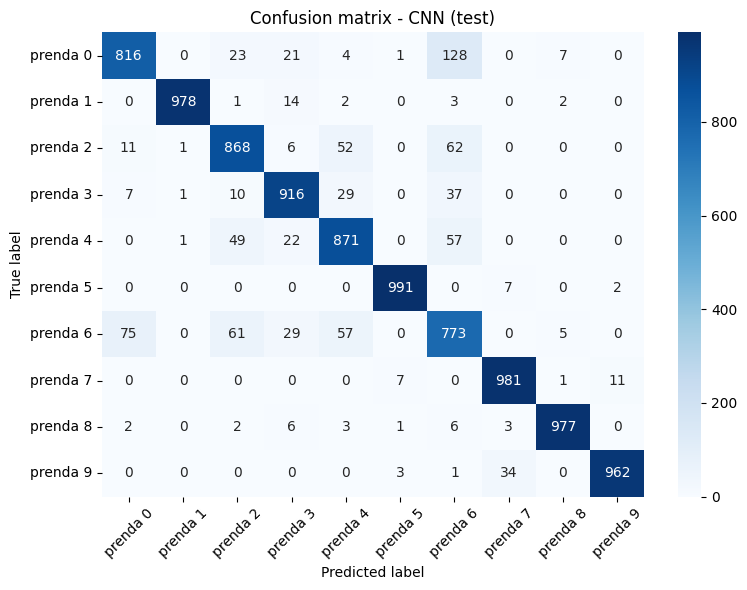

Classification report (test) - CNN:
              precision    recall  f1-score   support

    prenda 0       0.90      0.82      0.85      1000
    prenda 1       1.00      0.98      0.99      1000
    prenda 2       0.86      0.87      0.86      1000
    prenda 3       0.90      0.92      0.91      1000
    prenda 4       0.86      0.87      0.86      1000
    prenda 5       0.99      0.99      0.99      1000
    prenda 6       0.72      0.77      0.75      1000
    prenda 7       0.96      0.98      0.97      1000
    prenda 8       0.98      0.98      0.98      1000
    prenda 9       0.99      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



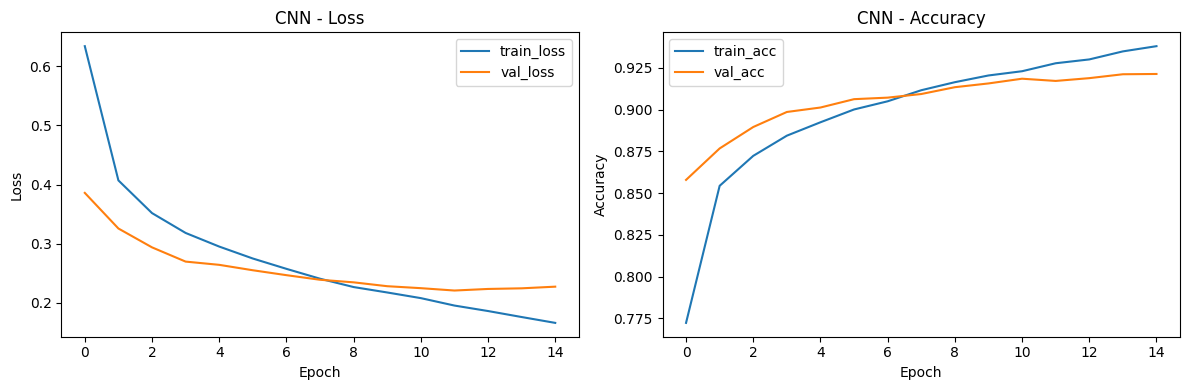

In [9]:
# CNN — entrenamiento y evaluación (con callbacks + métricas completas)
from keras.callbacks import EarlyStopping, ModelCheckpoint
print('\nEntrenando CNN con callbacks...')

# Preparar datos para CNN (ya normalizados en la celda GaussianNB)
X_train_cnn = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test_cnn = X_test.reshape((X_test.shape[0], 28, 28, 1))

cnn = build_cnn_model(
    input_shape=(28,28,1),
    num_classes=10,
    compile_model=True,
    learning_rate=0.001,)

callbacks_cnn = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('cnn_best.h5', save_best_only=True)
]

history_cnn = cnn.fit(X_train_cnn, y_train,
                      epochs=50,
                      batch_size=128,
                      validation_split=0.2,
                      callbacks=callbacks_cnn,
                      verbose=2)

# Evaluación con evaluate
loss_c, acc_c = cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f'CNN test accuracy (evaluate): {acc_c:.4f}')

# Guardar history
results = globals().get('results', {})
results['cnn'] = {'test_acc': acc_c, 'history': history_cnn.history}
globals()['results'] = results

# ---------- Métricas adicionales: predicciones, matriz de confusión, reporte de clasificación ----------
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predicciones del modelo (argmax sobre probabilidades)
y_pred_cnn = cnn.predict(X_test_cnn).argmax(axis=1)
acc_from_preds = accuracy_score(y_test, y_pred_cnn)
print(f'CNN test accuracy (from preds): {acc_from_preds:.4f}')

# Matriz de confusión
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Confusion matrix - CNN (test)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print('Classification report (test) - CNN:')
print(classification_report(y_test, y_pred_cnn, target_names=labels))

# ---------- Curvas de entrenamiento (loss / accuracy) ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history.get('loss', []), label='train_loss')
plt.plot(history_cnn.history.get('val_loss', []), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN - Loss')

plt.subplot(1,2,2)
acc_key = 'accuracy' if 'accuracy' in history_cnn.history else 'acc'
val_acc_key = 'val_' + acc_key
plt.plot(history_cnn.history.get(acc_key, []), label='train_acc')
plt.plot(history_cnn.history.get(val_acc_key, []), label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN - Accuracy')
plt.tight_layout()
plt.show()
